Assignnement 2: Prediction and Classification

Due: Sunday, May 01, 2016


# Introduction
Problem 3 is optional - for extra credit!
Problems 1 and 2 will be graded for the Lab 2.  


In this assignment you will be using regression and classification to explore different data sets.  

**First**: You will use data from before 2002 in the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) to create a metric for picking baseball players using linear regression.  This database contains the "complete batting and pitching statistics from 1871 to 2013, plus fielding statistics, standings, team stats, managerial records, post-season data, and more". [Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

!["Sabermetrics Science"](http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg)
http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg

**Second**: You will use the famous [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) data set to perform a $k$-neareast neighbor classification using cross validation.  While it was introduced in 1936, it is still [one of the most popular](http://archive.ics.uci.edu/ml/) example data sets in the machine learning community. Wikipedia describes the data set as follows: "The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres." Here is an illustration what the four features measure:

!["iris data features"](http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png)
http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png

**Third**: You will investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The [cars data set](https://archive.ics.uci.edu/ml/datasets/Automobile).  


## Load Python modules

In [1]:
# prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import itertools

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics
from sklearn import datasets, linear_model
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier

/Users/Deepthi/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Problem 1: Sabermetrics

Using data preceding the 2002 season pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary). Predict how many games this team would win in a 162 game season.  

In this problem we will be returning to the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics).  From this database, we will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. You will explore the data in this database from before 2002 and create a metric for picking players. 

#### Problem 1(a) 

Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [2]:
### Your code here ###
%cd /Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/Day 2/Assignment/Data/lahman-csv_2014-02-14

teams = pd.read_csv('Teams.csv')
players = pd.read_csv('Batting.csv')
salaries = pd.read_csv('Salaries.csv')
fielding = pd.read_csv('Fielding.csv')
master = pd.read_csv('Master.csv')

/Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/Day 2/Assignment/Data/lahman-csv_2014-02-14


#### Problem 1(b)

Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player. Show the head of the `medianSalaries` DataFrame.   

In [3]:
### Your code here ###

## Calculate median salary for every player
Median_salary = pd.DataFrame(salaries.groupby(['playerID'])['salary'].median()).reset_index()
Median_salary.columns = ['playerID','median_salary']

## Add the first name and last name for each player
medianSalaries = pd.merge(Median_salary,master,on='playerID')[['playerID','nameFirst','nameLast','median_salary']]

medianSalaries.head()

,playerID,nameFirst,nameLast,median_salary
0,aardsda01,David,Aardsma,419000
1,aasedo01,Don,Aase,612500
2,abadan01,Andy,Abad,327000
3,abadfe01,Fernando,Abad,451500
4,abbotje01,Jeff,Abbott,255000


#### Problem 1(c)

Now, consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. Create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

In [4]:
### Your code here ###

## Filter for the required criteria 
df = teams[(teams['G']>=162) & (teams['yearID'] > 1947)].copy()

## Calculate PA = AB + BB
df['PA'] = df['AB'] + df['BB']

## Calculate singles
df['1B'] = df['H']-df['2B']-df['3B']-df['HR']

## For each of singles, doubles, triples, HR and BB, calculate plate appearance rate
for i in ['1B','2B','3B','HR','BB']:
    df[i] = df[i]/df['PA']

## Get the required columns and create the stats dataframe
stats = df[['teamID','yearID','W','1B','2B','3B','HR','BB']]
stats.head()

,teamID,yearID,W,1B,2B,3B,HR,BB
1359,NYA,1961,109,0.161750,0.031793,0.006555,0.039331,0.088987
1360,DET,1961,101,0.165704,0.034488,0.008502,0.028874,0.107956
1361,BAL,1961,95,0.161828,0.037446,0.005939,0.024579,0.095843
1362,CHA,1961,86,0.176056,0.035375,0.007534,0.022601,0.090075
1364,BOS,1961,76,0.162632,0.040780,0.006011,0.018197,0.105118


#### Problem 1(d)

Is there a noticeable time trend in the rates computed computed in Problem 1(c)? 

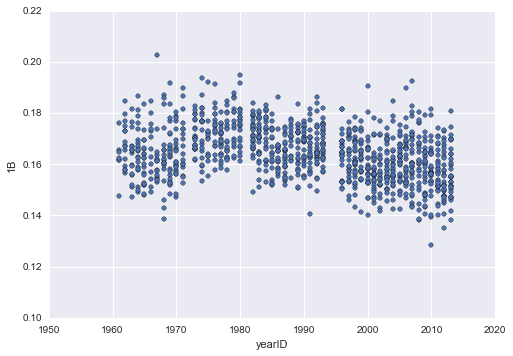

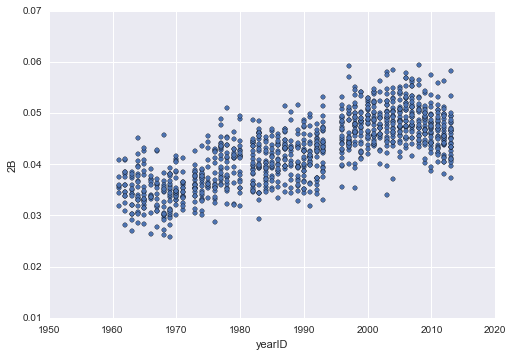

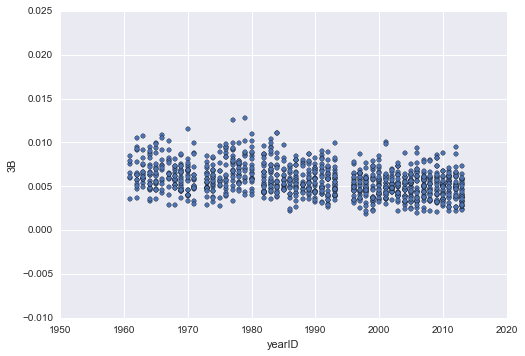

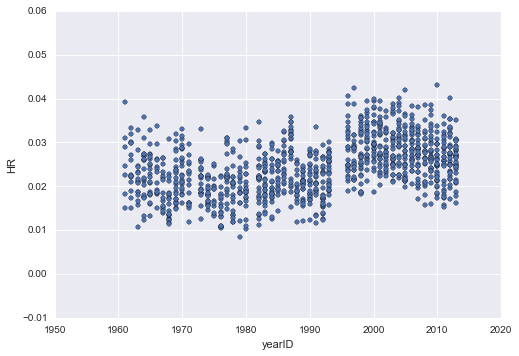

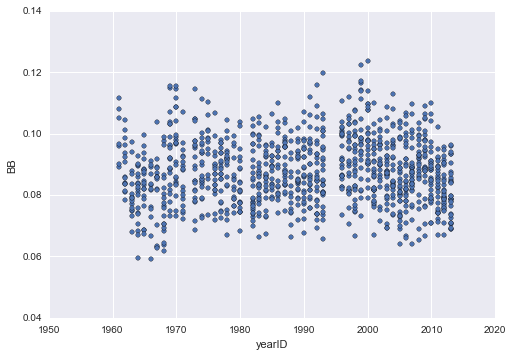

In [5]:
### Your code here ###

## Comments: 2B and HR seem to be trending higher over time, especially after 1990. While 1B is going down.
## 3B however, doesn't show any significant change in trend over time.
## Other rates don't have a significant time-trend.

for i in ['1B','2B','3B','HR','BB']:
    stats.plot(kind='scatter', x='yearID', y=i);

#### Problem 1(e) 

Using the `stats` DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates. 

In [6]:
### Your code here ###

## Standardizing all the rates to get the average across teams for each year 0
df = []
for yearID in stats['yearID'].unique():
    temp = stats[stats['yearID'] == yearID][['1B','2B','3B','HR','BB']].copy()
    temp2 = stats[stats['yearID'] == yearID]
    temp2[['1B','2B','3B','HR','BB']] = ((temp - temp.mean()) / temp.std())
    df.append(temp2)

stats_adj = pd.concat(df)

## To confirm that the mean is zero on all the columns
stats_adj.groupby('yearID')[['1B','2B','3B','HR','BB']].mean().mean().round()

/Users/Deepthi/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


1B   -0
2B   -0
3B    0
HR   -0
BB   -0
dtype: float64

#### Problem 1(f)

Build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002. Use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW). Hint: the new summary should be a linear combination of one to five of the five rates.


In [7]:
## The following piece of code iterates over all the combinations of features and calculates RSS. 
## Then the model with the lowest RSS is chosen to be the best one.

xs = ['1B','2B','3B','HR','BB']
vars_used = []
coefficients = []
intercept = []
RSS = []
for L in range(0, len(xs)+1):
    for subset in itertools.combinations(xs, L):
            if (len(list(subset))==0):
                continue
            else:
                stats_train_y = stats_adj[stats_adj['yearID'] <= 2002]['W']
                stats_train_x = stats_adj[stats_adj['yearID'] <= 2002][list(subset)]
                stats_test_y = stats_adj[stats_adj['yearID'] > 2002]['W']
                stats_test_x = stats_adj[stats_adj['yearID'] > 2002][list(subset)]
                regr = linear_model.LinearRegression()
                regr.fit(stats_train_x, stats_train_y)
                vars_used.append(list(subset))
                coefficients.append(list(regr.coef_))
                intercept.append(regr.intercept_)
                ## Calculate the average RSS from predictions to years past 2002
                RSS.append(np.mean((regr.predict(stats_test_x) - stats_test_y) ** 2))

print 'Best estimates (with low RSS) of OPW are obtained by using the following features:',
print vars_used[np.argmin(RSS)]
print 'The co-efficients obtained:', coefficients[np.argmin(RSS)]
print 'The intercept obtained:', intercept[np.argmin(RSS)]
print 'The minimum residual squared:', RSS[np.argmin(RSS)]

## Note: Based on my reading, 3B is the toughest to score (that's right, its even tougher than HR). 
## So, 3B might not be a big contributor in predicting wins. 
## This is proven by the fact that the best model selected based on RSS does not include 3B

Best estimates (with low RSS) of OPW are obtained by using the following features: ['1B', '2B', 'HR', 'BB']
The co-efficients obtained: [4.7053268835867348, 2.428485063684215, 4.0564344087336384, 4.6512125726854787]
The intercept obtained: 81.4426020408
The minimum residual squared: 82.0396086226


In [8]:
## Predicted OPW
stats_adj2 = stats_adj.copy()
stats_adj2['OPW'] = regr.predict(stats_adj[list(subset)])
stats_adj2.head()

,teamID,yearID,W,1B,2B,3B,HR,BB,OPW
1359,NYA,1961,109,-0.140899,-1.507695,-0.007669,1.664865,-1.183064,79.476915
1360,DET,1961,101,0.333666,-0.527529,1.193504,0.392544,0.961964,90.506239
1361,BAL,1961,95,-0.131593,0.548152,-0.388158,-0.129961,-0.407818,78.658691
1362,CHA,1961,86,1.576157,-0.205071,0.596050,-0.370694,-1.060020,82.500982
1364,BOS,1961,76,-0.035068,1.760332,-0.343273,-0.906529,0.640978,83.191123


** Your answer here: **

Using the linear regression model, I found that the variables - 1B, 2B, HR and BB generate the best model with minimum RSS value.

** Note: **
Based on my reading, 3B is the toughest to score (that's right, its even tougher than HR). So, 3B might not be a big contributor in predicting wins. This is proven by the fact that the best model selected based on RSS does not include 3B

#### Problem 1(g)

Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances. Consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year compute singles, doubles, triples, HR, BB per plate appearance rates. Create a new pandas DataFrame called `playerstats` that has the playerID, yearID and the rates of these stats.  Remove the average for each year as for these rates as done in Problem 1(e). 

In [9]:
### Your code here ###

df = players[(players['G']>=162) & (players['yearID'] > 1947)].copy()

## Calculate PA = AB + BB
df['PA'] = df['AB'] + df['BB']

df = df[df['PA'] >= 500]

## Calculate singles
df['1B'] = df['H']-df['2B']-df['3B']-df['HR']

## For each of singles, doubles, triples, HR and BB, calculate plate appearance rate
for i in ['1B','2B','3B','HR','BB']:
    df[i] = df[i]/df['PA']

## Get the required columns and create the playerstats dataframe
playerstats = df[['playerID','yearID','1B','2B','3B','HR','BB']]

In [10]:
## Standardize the players data for each year

df = []
for yearID in playerstats['yearID'].unique():
    temp = playerstats[playerstats['yearID'] == yearID][['1B','2B','3B','HR','BB']].copy()
    temp2 = playerstats[playerstats['yearID'] == yearID]
    temp2[['1B','2B','3B','HR','BB']] = ((temp - temp.mean()) / temp.std())
    df.append(temp2)

playerstats = pd.concat(df)

Show the head of the `playerstats` DataFrame. 

In [11]:
### Your code here ###
playerstats.head()

,playerID,yearID,1B,2B,3B,HR,BB
208,abreubo01,2001,-1.212825,1.775116,0.107445,-0.167059,1.017177
12284,cabreor01,2001,0.769774,0.873891,1.078940,-1.157486,-1.068767
21079,delgaca01,2001,-0.997527,-0.959730,-1.197160,0.344624,1.236613
31888,gonzalu01,2001,-0.606425,-0.328285,1.353103,1.323320,0.741433
51519,longte01,2001,1.530662,0.078488,0.140797,-1.295385,-0.783845


#### Problem 1(h)

Using the `playerstats` DataFrame created in Problem 1(g), create a new DataFrame called `playerLS` containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the avaerage of the rates by year (a more correct way is to go back to the totals). 

In [12]:
### Your code here ###
playerLS = pd.merge(playerstats, master, on='playerID')
playerLS['career_start_year']= playerLS['debut'].apply(lambda x: int(x[0:4]))
playerLS['career_end_year']= playerLS['finalGame'].apply(lambda x: int(x[0:4]))

playerLS = playerLS[['playerID','career_start_year','career_end_year','1B','2B','3B','HR','BB']]\
                .groupby(['playerID','career_start_year','career_end_year']).mean().reset_index()

Show the head of the `playerLS` DataFrame. 

In [13]:
### Your code here ###
playerLS.head()

,playerID,career_start_year,career_end_year,1B,2B,3B,HR,BB
0,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686
1,allendi01,1963,1977,-0.155744,1.190421,1.818839,0.763955,0.644211
2,alomasa01,1964,1978,0.707107,-0.707107,-0.707107,-0.707107,-0.707107
3,alouma01,1960,1974,1.529468,1.575523,0.347749,-1.251338,-0.947769
4,bagweje01,1991,2005,-1.032858,1.004970,-0.334311,0.778493,1.296231


#### Problem 1(i)

Compute the OPW for each player based on the average rates in the `playerLS` DataFrame. You can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. Add this column to the playerLS DataFrame. Call this colum OPW.

In [14]:
### Your code here ###

## Create the best model based on the selected variables in 1f. 
stats_train_y = stats_adj[stats_adj['yearID'] <= 2002]['W']
stats_train_x = stats_adj[stats_adj['yearID'] <= 2002][['1B', '2B', 'HR', 'BB']]
stats_test_y = stats_adj[stats_adj['yearID'] > 2002]['W']
stats_test_x = stats_adj[stats_adj['yearID'] > 2002][['1B', '2B', 'HR', 'BB']]
regr = linear_model.LinearRegression()
regr.fit(stats_train_x, stats_train_y)

## Predict 'OPW' for the players in playerLS
playerLS["OPW"] = regr.predict(playerLS[['1B', '2B', 'HR', 'BB']])
playerLS.head()

,playerID,career_start_year,career_end_year,1B,2B,3B,HR,BB,OPW
0,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686,85.077402
1,allendi01,1963,1977,-0.155744,1.190421,1.818839,0.763955,0.644211,89.695993
2,alomasa01,1964,1978,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,76.895336
3,alouma01,1960,1974,1.529468,1.575523,0.347749,-1.251338,-0.947769,82.981139
4,bagweje01,1991,2005,-1.032858,1.004970,-0.334311,0.778493,1.296231,88.210171


#### Problem 1(j)

Add four columns to the `playerLS` DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, DH or OF), first name, last name and median salary. 

In [15]:
### Your code here ###

## Get median salary
median_salaries = salaries[['playerID','salary']].groupby('playerID').median().reset_index()

## Merge with fielding dataset to get 'POS'
playerLS = pd.merge(playerLS,fielding,on='playerID')[['playerID', 'career_start_year', 'career_end_year', '1B', '2B', '3B', 'HR', 'BB', 'OPW','POS']]

## Filter out for positions
playerLS = playerLS[playerLS['POS'].isin(['C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'DH' ,'RF', 'OF'])].drop_duplicates()

## Add the median_salary into playerLS dataset
playerLS = pd.merge(playerLS,median_salaries,on='playerID')

Show the head of the `playerLS` DataFrame. 

In [16]:
### Your code here ###

playerLS.head()

,playerID,career_start_year,career_end_year,1B,2B,3B,HR,BB,OPW,POS,salary
0,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686,85.077402,LF,9000000
1,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686,85.077402,OF,9000000
2,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686,85.077402,RF,9000000
3,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686,85.077402,CF,9000000
4,abreubo01,1996,2012,-0.954927,0.918221,-0.345258,-0.187583,1.431686,85.077402,DH,9000000


#### Problem 1(k)

Subset the `playerLS` DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship bewteen the median salary (in millions) and the predicted number of wins. 

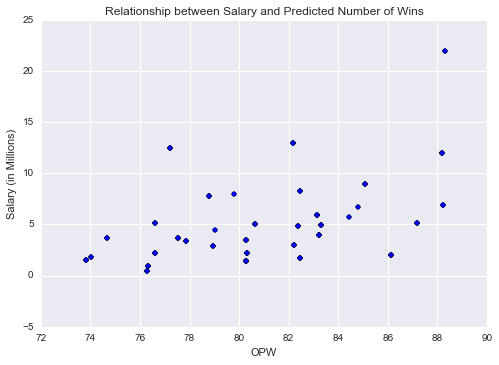

In [17]:
### Your code here ###

## Get the list of playsers active in 2002 and 2003 and who have played atleast 3 years.
active_players = playerLS[(playerLS['career_start_year'] <= 2002) & (playerLS['career_end_year'] >= 2003)&\
                (playerLS["career_end_year"] - playerLS["career_start_year"] >= 3)]

## Plot to understand the median salary and predicted number of wins
fig = plt.figure()
ax = fig.gca()
ax.scatter(active_players.OPW,active_players.salary/10**6)
ax.set_ylabel('Salary (in Millions)')
ax.set_xlabel('OPW')
ax.set_title('Relationship between Salary and Predicted Number of Wins')
plt.show()

#### Problem 1(l)
Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.

In [18]:
## Create rank on salary for every position. 
## Note: Since the question doesn't ask for optimizing on the OPW, I am picking a set of players to satisfy the 
## salary criteria
active_players['rnk'] = active_players.groupby(['POS'])['salary'].rank(ascending = True)

top_players = active_players[active_players['rnk']==3].sort('salary')
top_players

/Users/Deepthi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,playerID,career_start_year,career_end_year,1B,2B,3B,HR,BB,OPW,POS,salary,rnk
439,surhobj01,1987,2005,0.718752,0.406501,-0.498026,-0.525086,-0.727656,80.297289,DH,1416667,3
110,cruzjo02,1997,2008,-1.136183,-1.239633,0.120934,0.376450,-0.170862,73.818385,CF,1500000,3
111,cruzjo02,1997,2008,-1.136183,-1.239633,0.120934,0.376450,-0.170862,73.818385,LF,1500000,3
112,cruzjo02,1997,2008,-1.136183,-1.239633,0.120934,0.376450,-0.170862,73.818385,OF,1500000,3
114,cruzjo02,1997,2008,-1.136183,-1.239633,0.120934,0.376450,-0.170862,73.818385,RF,1500000,3
362,perezne01,1996,2007,1.326771,-0.787052,1.651681,-1.494545,-1.218627,74.043534,2B,1856250,3
363,perezne01,1996,2007,1.326771,-0.787052,1.651681,-1.494545,-1.218627,74.043534,SS,1856250,3
364,perezne01,1996,2007,1.326771,-0.787052,1.651681,-1.494545,-1.218627,74.043534,3B,1856250,3
172,gonzalu01,1990,2008,-0.048984,-0.008314,0.343072,0.806056,0.355251,86.113988,1B,2025000,3
226,ibanera01,1996,2013,0.068034,0.249688,-0.463641,-0.366205,-0.134070,80.260013,C,3458333,3


In [19]:
print 'Total salary of the selected 10 players:', top_players['salary'].sum()
print 'Mean OPW of the selected 10 players:',top_players['OPW'].mean()

Total salary of the selected 10 players: 18468750
Mean OPW of the selected 10 players: 76.4075433088


#### Problem 1(m)
What do these players outperform in? Singles, doubles, triples HR or BB?

In [20]:
### Your code here ###

## To understand this question, I am going to look at those features with maximum positive rates
## Multiply the features by 100 just for the sake of readability
top_players[['1B','2B','3B','HR','BB']]=top_players[['1B','2B','3B','HR','BB']]*100

top_players.sort('OPW',ascending = False)

,playerID,career_start_year,career_end_year,1B,2B,3B,HR,BB,OPW,POS,salary,rnk
172,gonzalu01,1990,2008,-4.898368,-0.831416,34.307200,80.605556,35.525141,86.113988,1B,2025000,3
439,surhobj01,1987,2005,71.875226,40.650131,-49.802599,-52.508610,-72.765592,80.297289,DH,1416667,3
226,ibanera01,1996,2013,6.803401,24.968819,-46.364060,-36.620519,-13.407008,80.260013,C,3458333,3
362,perezne01,1996,2007,132.677149,-78.705173,165.168106,-149.454498,-121.862732,74.043534,2B,1856250,3
363,perezne01,1996,2007,132.677149,-78.705173,165.168106,-149.454498,-121.862732,74.043534,SS,1856250,3
364,perezne01,1996,2007,132.677149,-78.705173,165.168106,-149.454498,-121.862732,74.043534,3B,1856250,3
110,cruzjo02,1997,2008,-113.618305,-123.963336,12.093379,37.644957,-17.086209,73.818385,CF,1500000,3
111,cruzjo02,1997,2008,-113.618305,-123.963336,12.093379,37.644957,-17.086209,73.818385,LF,1500000,3
112,cruzjo02,1997,2008,-113.618305,-123.963336,12.093379,37.644957,-17.086209,73.818385,OF,1500000,3
114,cruzjo02,1997,2008,-113.618305,-123.963336,12.093379,37.644957,-17.086209,73.818385,RF,1500000,3


** Your answer here: **

Most of the selected 10 players outperform in 1B.

### Use one of the classification methods to predict wheather a player will be an Allstar?

In [21]:
### Your code here ###

## Get the allstar data
allstar = pd.read_csv('AllstarFull.csv')

## Clean up the data
allstar2 = allstar[['playerID','yearID','GP']].drop_duplicates()

## Get the GP - all star flag from the allstar file
players_allstar_flag = pd.merge(players,allstar2,on=['playerID','yearID'],how ='left')

players_allstar_flag['GP'] = players_allstar_flag['GP'].fillna(0)


In [22]:
## Using KNN classifier to predict wheather a player will be an Allstar

## Get only numeric features and handle nulls
x = players_allstar_flag.drop('GP',axis=1)._get_numeric_data().fillna(0)
y = players_allstar_flag['GP']

## Split the data into train and test (66%-33% split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=4)

## Fit the KNN classifer and predict the allstar player
neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(x_train, y_train) 
z = pd.DataFrame(zip(neigh.predict(x_test),y_test),columns = ['predicted','actual'])

## Calculate the error rate
z['new'] = z['actual']-z['predicted']
print 'Error rate =', round(z[z['new']<>0]['new'].count()*100.0/z['new'].count(),2),'%'

Error rate = 3.44 %


## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

#### ** Data Exploration: **
In this problem, we saw that 2B and HR have an increasing trend over time while 1B has been decreasing , especially after 1990. 3B however has stayed constant over time. 

#### ** Prediction of winners: **
The above observation hints at the fact that 3B might not be a big factor in predicting the winner. This has been proven when the significant variables were chosen. Only 1B, 2B, HR and BB seem to be significant predictors of winners (with a minimum RSS).

#### ** Selecting top 10 players: **
When selecting the 10 customers, for each position, a few assumptions are made:
1. Any player, irrespective of the fact that they are currently active or not has been considered
2. If the same player holds different positions, then he is condidered more than once
3. The 10 players have been selected to optimize only on the salary (and not on OPW) as the problem does not explicitly require us to optimize on OPW.

Based on the above assumptions the 10 players selected had the following total salary and OPW:
1. Total salary of the selected 10 players: $18,468,750
2. Mean OPW of the selected 10 players: 76.41

Also, the selected 10 players outperform in 1B.

#### ** Classification: **
For the classification exercise, I've used allstarfull.csv file. Here K-nearest neighbors method has been used. The data has been split into training and test sets (66% & 33% respectively.). Using this model, an accuracy of 96.66% has been achieved.



# Problem 2:  $k$-Nearest Neighbors and Cross Validation 

What is the optimal $k$ for predicting species using $k$-nearest neighbor classification 
on the four features provided by the iris dataset.

In this problem you will get to know the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library. In addition to Pandas, it is one of the most useful libraries for data scientists. 
For the Iris data set  sklearn provides an extra function to load it - since it is one of the very commonly used data sets.

In [23]:
#load the iris data set

from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation

iris = datasets.load_iris()
x = iris.data
y = iris.target

#### Problem 2(a) 
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets you have created. 

In [24]:
### Your code here ###

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=4)

print 'Dimensions of the test and train data sets'
print '\n', 'x_train =',np.shape(x_train),'\n'
print 'x_test =',np.shape(x_test),'\n'
print 'y_train =',np.shape(y_train),'\n'
print 'y_test =',np.shape(y_test),'\n'

Dimensions of the test and train data sets

x_train = (100, 4) 

x_test = (50, 4) 

y_train = (100,) 

y_test = (50,) 



#### Problem 2(b) 

 Use ***ten fold cross validation*** to estimate the optimal value for $k$ for the iris data set. 

**Note**: For your convenience sklearn does not only include the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), but also a [grid search function](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). The function is called grid search, because if you have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set. 

In [25]:
### Your code here ###

## Fit a KNN classifier  model
neigh = KNeighborsClassifier()

n_neighbor = range(1,21)
param_grid = { 
    'n_neighbors': range(1,21)
}

## Use gridsearch and 10 fold cross validation on the train data set
grid = GridSearchCV(estimator=neigh, param_grid=param_grid, cv=10)
return_val = grid.fit( x_train, y_train )
print 'Best score obtained using grid search:',(grid.best_score_)
print 'Best parameter obtained using grid search:',return_val.best_params_
gridscores = return_val.grid_scores_



Best score obtained using grid search: 0.99
Best parameter obtained using grid search: {'n_neighbors': 12}


#### Problem 2(c)

Visualize the result by plotting the score results versus values for $k$. 

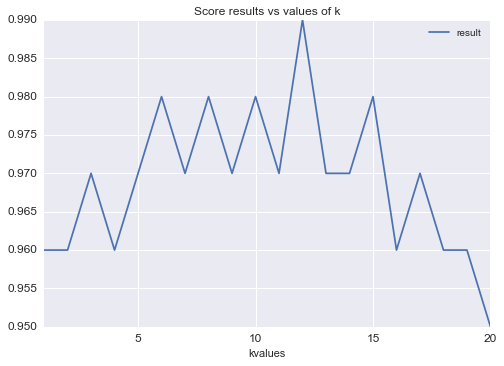

In [26]:
### Your code here ###

## Plot the grid scores obtained for several values of k (n_neighbors)

result = []
kvalues = range(1,21)
for i in range(0,len(gridscores)):
    result.append(gridscores[i][1])
    
result_plot = pd.DataFrame(zip(kvalues,result), columns = ['kvalues','result'])

result_plot.plot(x='kvalues',y='result', title = 'Score results vs values of k',fontsize = 12)
plt.show()

Verify that the grid search has indeed chosen the right parameter value for $k$.

The best value of n_neighbors obtained without gridsearch: 12


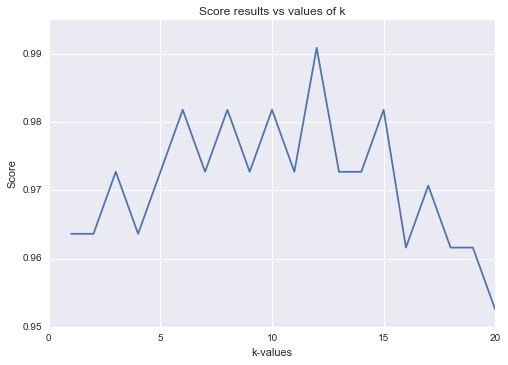

In [27]:
### Your code here ###

## Manually run KNN with different values of n_neighbors to validate grid search. 
## Use 10 fold cross validation to maintain consistency with previous step

scores=[]
for i in range(1,21):
    neigh = KNeighborsClassifier(n_neighbors=i)
    score = np.mean(cross_validation.cross_val_score(neigh, x_train, y_train, cv=10))
    scores.append(score)
    
print 'The best value of n_neighbors obtained without gridsearch:',np.argmax(scores)+1
plt.plot(list(range(1,21)), scores)
plt.xlabel('k-values')
plt.ylabel('Score')
plt.title('Score results vs values of k')
plt.show()

#### Problem 2(d)

Test the performance of our tuned KNN classifier on the test set.

In [28]:
### Your code here ###

## With the selected value of n_neighbors = 12, run KNN classifier on the test dataset.

neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(x_train, y_train) 
z = pd.DataFrame(zip(neigh.predict(x_test),y_test),columns = ['predicted','actual'])

z['new'] = z['actual']-z['predicted']
print 'Error rate =', z[z['new']<>0]['new'].count()*100.0/z['new'].count(),'%'
print 'Accuracy =', (100 - z[z['new']<>0]['new'].count()*100.0/z['new'].count()), '%'


Error rate = 2.0 %
Accuracy = 98.0 %


## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

In this problem, the Iris data was first split into train and test in the ratio 66%,33% respectively. 

To obtain a the best value for the n_neighbors feature, gridsearch function was used on the training data set. This process was subjected to 10-fold cross validation to obtain a reliable value for the n_neighbors feature. Using these two methods, n_neighbors = 12 was obtained. 

To ensure that the grid search indeed provided a good estimate, the KNN algorithm was manually iterated through several values of n_neighbors and 10-fold cross validation and an identical value of 12 was obtained. Thus proving the results obtained by gridsearch were accurate.

Using the n_neighbors=12, the test data set yielded a good 98% accuracy.

## Problem 3:  Investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The cars data

#### Download the UCI ML automobile dataset. (https://archive.ics.uci.edu/ml/datasets/Automobile)

In [29]:
### Your code here ###

## Set directory
%cd /Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/Day 2/Assignment/Data/Cars data

/Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/Day 2/Assignment/Data/Cars data


In [30]:
## List of column headers
col_header=['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors', 'body-style', 'drive-wheels',     
'engine-location', 'wheel-base','length',  'width','height','curb-weight', 'engine-type',  'num-of-cylinders', 
'engine-size',  'fuel-system',  'bore', 'stroke',  'compression-ratio','horsepower','peak-rpm', 'city-mpg',         
'highway-mpg', 'price' ]

In [31]:
## Import the data
cars_data_raw = pd.read_csv('imports-85.data.txt',header=-1)
cars_data_raw.columns = col_header

## Clean up the '?' in the data and replace with NaN
cars_data_raw=cars_data_raw.replace('?', np.nan)

## Some columns aren't in number fromat. So convert them into numeric values
convert_to_num = ['bore','stroke','horsepower','peak-rpm','price']
cars_data_raw[convert_to_num]=cars_data_raw[convert_to_num].astype(float, inplace=True)


/Users/Deepthi/anaconda/lib/python2.7/site-packages/pandas/core/common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [32]:
## Clean up NANs
cars_target = cars_data_raw['price'].fillna(0)
cars_data = cars_data_raw.drop('price',axis=1).fillna(0)

cols = np.array(cars_data.columns)

## Tokenize the nominal variables
for colname in cols[1:]:
    dt = cars_data[colname].dtypes
    if dt not in [np.float64, np.int64]:
        cars_data[colname] = pd.factorize(cars_data[colname])[0]
        

#### Find the mostimportant features

Selected features:
['width', 'curb-weight', 'engine-size', 'horsepower', 'highway-mpg']


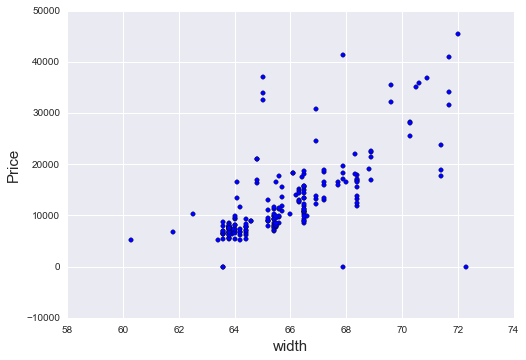

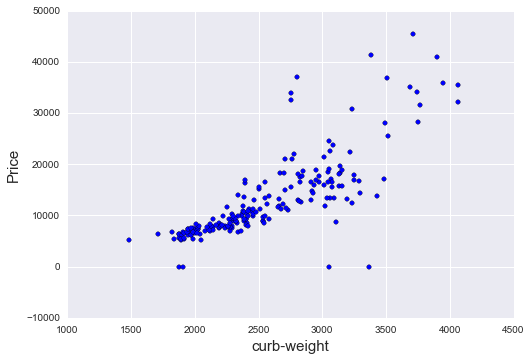

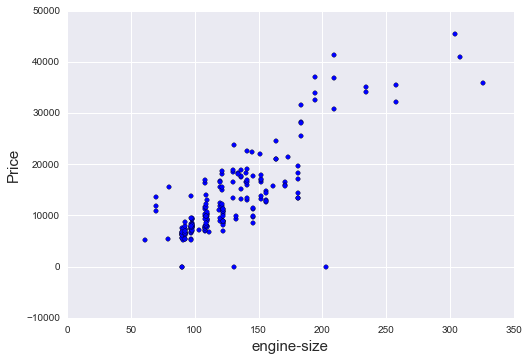

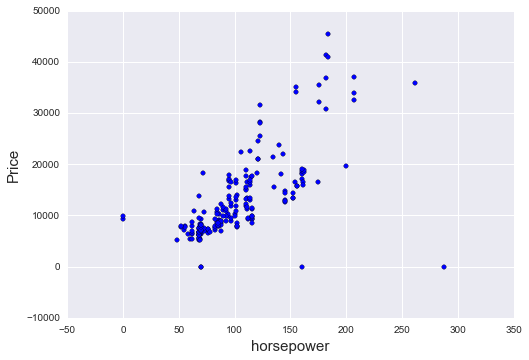

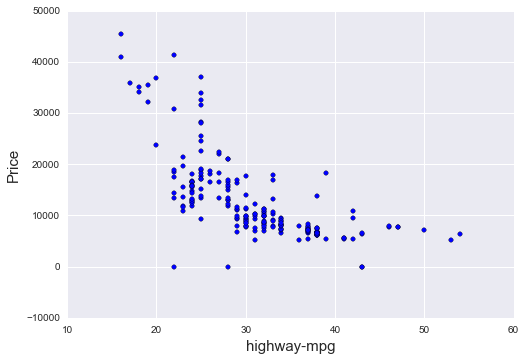

In [33]:
### Your code here ###

from sklearn.feature_selection import *
fs=SelectKBest(score_func=f_regression,k=5)
X_new=fs.fit_transform(cars_data,cars_target)


df = pd.DataFrame(zip(fs.get_support(),cars_data.columns))
print 'Selected features:'
print list(df[df[0]==1][1])


## Plot each of the selected variable vs. Price to understand the relationship
for i in range(5):
    plt.scatter(X_new[:,i],cars_target)
    plt.xlabel(list(df[df[0]==1][1])[i], fontsize=15)
    plt.ylabel('Price', fontsize=15)
    plt.show()


#### Using 10-fold cross validation separate the test and training data sets

In [34]:
### Your code here ###

## Define the features and the predicted variable 
temp = cars_data_raw.dropna()
X = temp[list(df[df[0]==1][1])]
y = temp['price']

## Define a function that will split the data into test and train using 10-fold cross validation
from sklearn.cross_validation import *
def train_and_evaluate(clf, X_train, y_train):    
    clf.fit(X_train, y_train)    
    print "Coefficient of determination on training set:",clf.score(X_train, y_train)    
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(X_train.shape[0], 10, shuffle=True, random_state=4)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print "Average coefficient of determination using 10-fold crossvalidation:",np.mean(scores)

#### Normalize the data

In [35]:
### Your code here ###

## I have standardized the data by dividing by standard deviation as I believe that this yields better results
X=((X - X.mean()) / X.std())
X.head()

,width,curb-weight,engine-size,horsepower,highway-mpg
3,0.304152,-0.257580,-0.335724,0.200645,-0.322294
4,0.406828,0.752917,0.550661,0.623841,-1.560840
6,2.973718,0.794415,0.550661,0.461073,-1.096385
8,2.973718,1.296551,0.386516,1.437681,-1.870477
10,-0.414577,-0.137233,-0.368553,0.168091,-0.477113


#### Start with a lineal model and evaluate how well it can predict the price variable

In [36]:
### Your code here ###
lm = sklearn.linear_model.LinearRegression()
train_and_evaluate(lm,X,y)

Coefficient of determination on training set: 0.829692467808
Average coefficient of determination using 10-fold crossvalidation: 0.770824309772


#### Try using Ridge regression and evaluate the result of the 10-fold cross-validation

In [37]:
### Your code here ###
rm = sklearn.linear_model.Ridge()
train_and_evaluate(rm,X,y)

Coefficient of determination on training set: 0.829658877611
Average coefficient of determination using 10-fold crossvalidation: 0.771733944412


#### Train the Regression Tree and evaluate using 10-fold cross validation; Specify the parameters used and how you changed them to increase the accuracy

In [38]:
### Your code here ###
from sklearn.tree import DecisionTreeRegressor
dtr = sklearn.tree.DecisionTreeRegressor()
train_and_evaluate(dtr,X,y)

Coefficient of determination on training set: 0.99913700285
Average coefficient of determination using 10-fold crossvalidation: 0.779528352881


#### Discussion for Problem 3  Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.Compare all three aproaches and discuss your findings in 100 words or less

In this problem, the top features to predict the price of a car were selected using sklearn.feature_selection module. The following 5 features were selected and they proved to provide some good results.
['width', 'curb-weight', 'engine-size', 'horsepower', 'highway-mpg']

Here, 10-fold cross validation method was used to obtain a reliable result. Among the three regression models that were built, regression tree yielded the best results with and rsquare of 0.82. While, linear regression and ridge regression models yielded very similar reuslts with an rsquare of 0.77